Pour ce second exercice,l'objectif sera d'implémenter et de visualiser quatre approches de discrétisation différentes sur le jeu de données **Wines**.

La **discrétisation** consiste à transformer une variable numérique continue en une variable catégorielle (discrète) avec un nombre fini d'intervalles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

sns.set_theme(style="whitegrid")

column_names = [
    'target', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 
    'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 
    'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'
]

df_wine=pd.read_csv('../data/wine.csv', header=None, names=column_names)
df_wine['target']=df_wine['target'] - 1

feature='alcohol'
n_interv=4

## 1. Largeur d'intervalle egale

**Principe**: Cette methode divise la plage de valeurs (de min a max) en k intervalles de taille identique. Pour calculer la largeur de chaque intervalle on utilise la formule **largeur= (max-min) / k**

/tmp/ipykernel_10864/278529297.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_wine['alcohol_equal_width'], ax=axes[1],palette='viridis')


Limites des intervalles calculees :
[np.float64(11.03), np.float64(11.98), np.float64(12.93), np.float64(13.879999999999999), np.float64(14.83)]

Distribution dans les nouveaux bins:
alcohol_equal_width
Interval_3    68
Interval_2    65
Interval_4    26
Interval_1    19
Name: count, dtype: int64


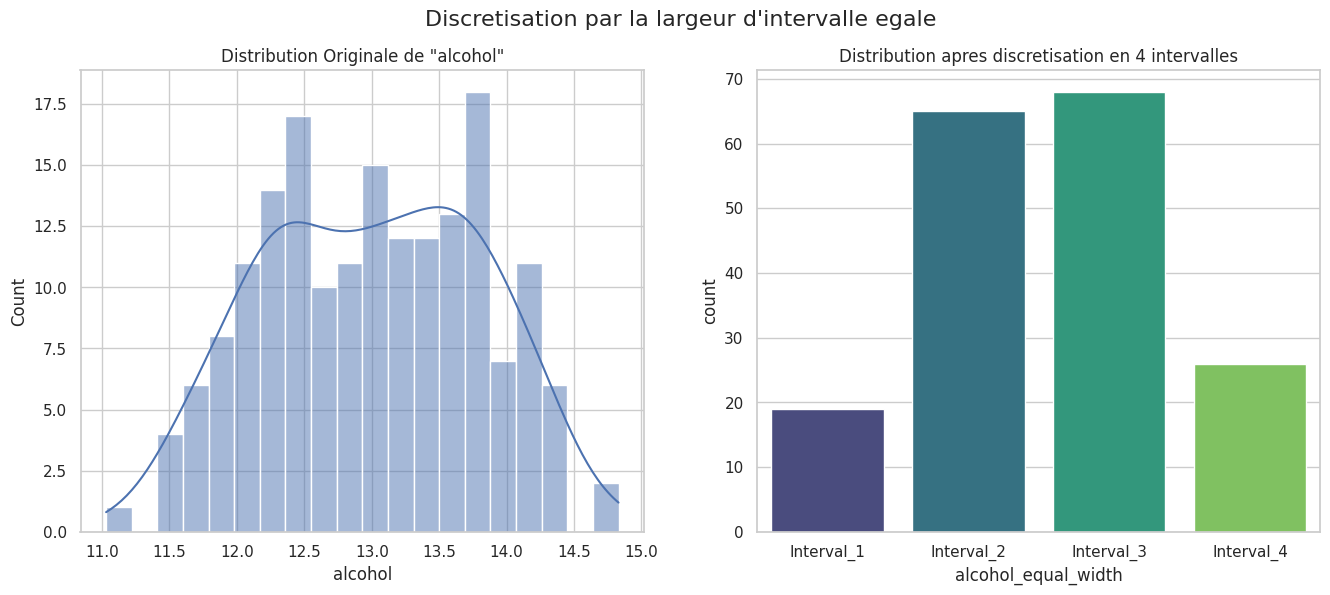

In [2]:
def discretize_equal_width(data, feature, n_bins):
    min_val=data[feature].min()
    max_val=data[feature].max()
    interval_width=(max_val - min_val)/ n_bins

    bins=[min_val + i * interval_width for i in range (n_bins +1)]
    labels= [f'Interval_{i+1}' for i in range (n_bins)]
    #Application de la discretisation
    discretized_feature=pd.cut(data[feature], bins=bins, labels=labels, include_lowest=True)

    return discretized_feature, bins

#Utilisation de la methode

df_wine['alcohol_equal_width'], bins_ew =discretize_equal_width(df_wine, feature, n_interv)

fig, axes= plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Discretisation par la largeur d\'intervalle egale', fontsize=16)

sns.histplot(df_wine[feature], kde=True, ax=axes[0], bins=20)
axes[0].set_title(f'Distribution Originale de "{feature}"')

sns.countplot(x=df_wine['alcohol_equal_width'], ax=axes[1],palette='viridis')
axes[1].set_title(f'Distribution apres discretisation en {n_interv} intervalles')
plt.show

print("Limites des intervalles calculees :")
print(bins_ew)
print("\nDistribution dans les nouveaux bins:")
print(df_wine['alcohol_equal_width'].value_counts())

## 2. Fréquence Égale 

**Principe**: Cette méthode divise les données en `k` intervalles de sorte que chaque intervalle contienne (approximativement) le même nombre d'observations.


/tmp/ipykernel_10864/3832939795.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_wine['alcohol_equal_freq'], ax=axes[1], palette='viridis')


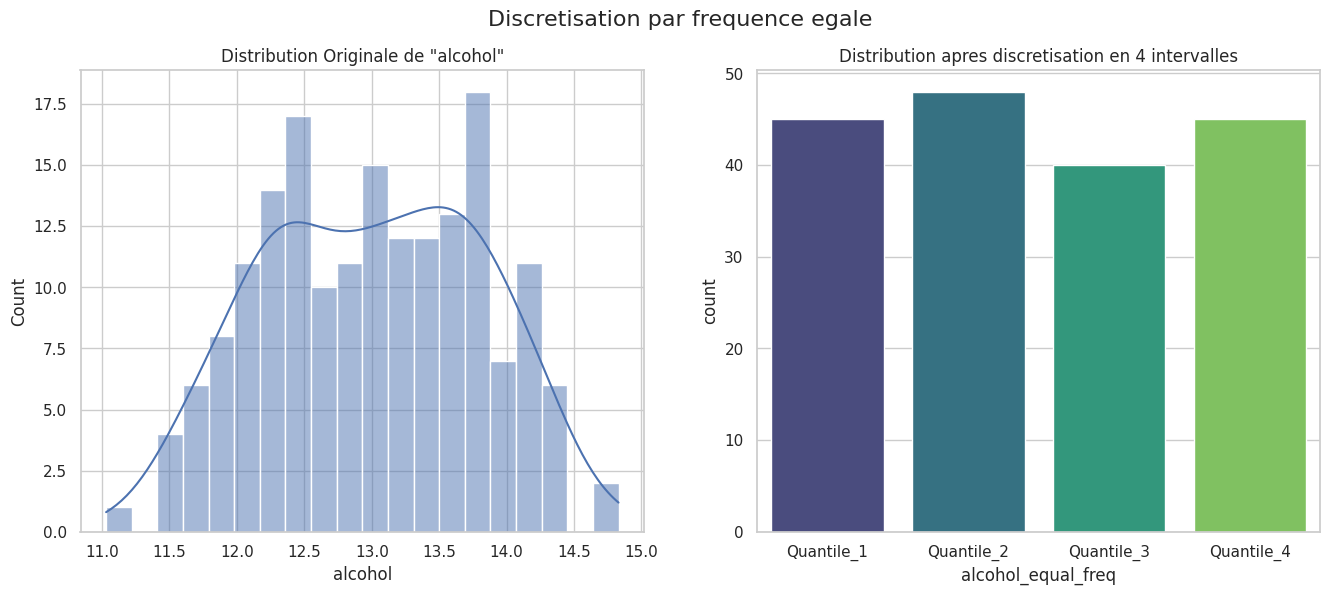

Limites des intervalles calculees:
[11.03   12.3625 13.05   13.6775 14.83  ]

 Distribution dans les nouveaux intervalles
alcohol_equal_freq
Quantile_2    48
Quantile_1    45
Quantile_4    45
Quantile_3    40
Name: count, dtype: int64


In [3]:
def discretize_equal_frequency(data, feature, n_bins):
    # Les labels sont générés directement ici
    labels = [f'Quantile_{i+1}' for i in range(n_bins)]
    
    # qcut calcule les bornes ET effectue la discrétisation en une seule étape
    discretized_feature, bins = pd.qcut(
        data[feature], 
        q=n_bins, 
        labels=labels, # On fournit directement les labels
        retbins=True, 
        duplicates='drop'
    )
    
    return discretized_feature, bins


#Utilisation de la methode
df_wine['alcohol_equal_freq'], bins_ef=discretize_equal_frequency(df_wine, feature, n_interv)

fig, axes=plt.subplots(1,2, figsize=(16,6))
fig.suptitle('Discretisation par frequence egale', fontsize=16)

sns.histplot(df_wine[feature], kde=True, ax=axes[0], bins=20)
axes[0].set_title(f'Distribution Originale de "{feature}"')

sns.countplot(x=df_wine['alcohol_equal_freq'], ax=axes[1], palette='viridis')
axes[1].set_title(f'Distribution apres discretisation en {n_interv} intervalles')
plt.show()

print("Limites des intervalles calculees:")
print(bins_ef)
print("\n Distribution dans les nouveaux intervalles")
print(df_wine['alcohol_equal_freq'].value_counts())
                

## 3. Discrétisation Basée sur le Clustering

**Principe**:Cette méthode utilise un algorithme de clustering (dans notre cas nous utiliserons KMeans) pour regrouper les valeurs en `k` clusters.

/tmp/ipykernel_10864/735865196.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_wine['alcohol_kmeans'].sort_values(), ax=axes[1], palette='viridis')


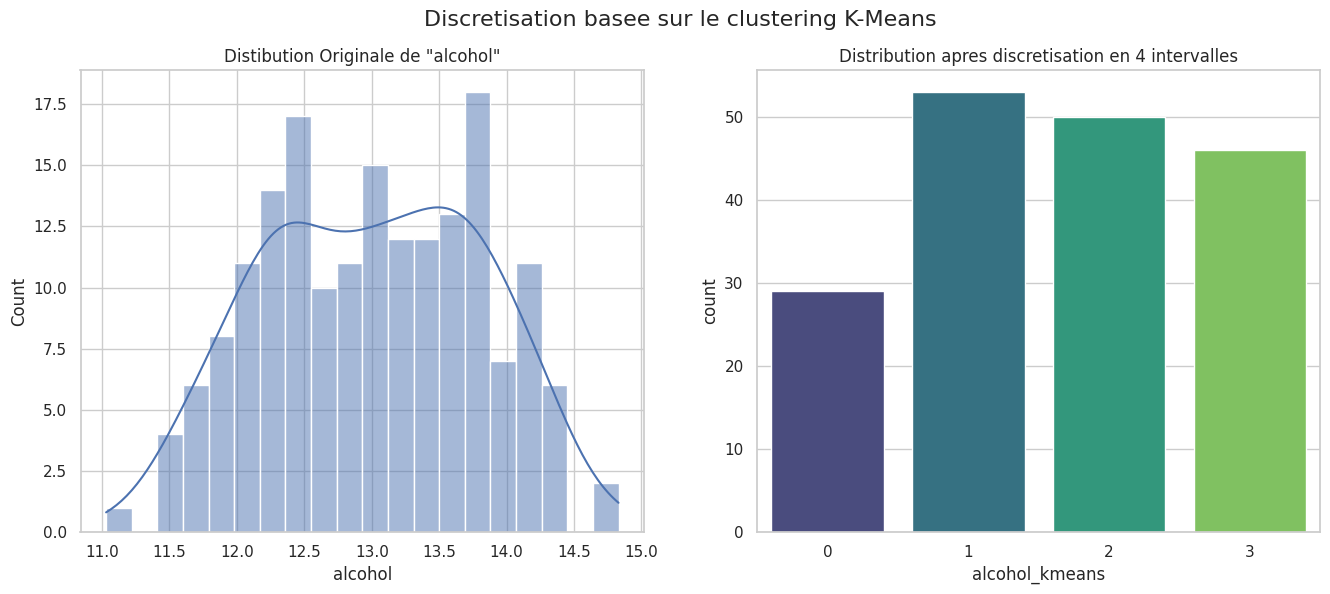


Distribution dans les nouveaux intervalles
alcohol_kmeans
0    29
1    53
2    50
3    46
Name: count, dtype: int64


In [4]:
def discretize_kmeans(data, feature, n_bins):
    kmeans= KMeans(n_clusters=n_bins, random_state=42, n_init=10)

    labels=kmeans.fit_predict(data[[feature]].values)

    discretized_feature =pd.Series(labels, index=data.index, name=f'{feature}_kmeans_cluster')

    df_temp = data.copy()
    df_temp['cluster']=labels
    cluster_order = df_temp.groupby('cluster')[feature].mean().sort_values().index

    relabel_map={old_label: new_label for new_label, old_label in enumerate(cluster_order)}
    discretized_feature =discretized_feature.map(relabel_map).astype('category')

    return discretized_feature

df_wine['alcohol_kmeans']=discretize_kmeans(df_wine, feature, n_interv)

fig, axes=plt.subplots(1,2, figsize=(16, 6))
fig.suptitle('Discretisation basee sur le clustering K-Means', fontsize=16)

sns.histplot(df_wine[feature], kde=True, ax=axes[0], bins=20)
axes[0].set_title(f'Distibution Originale de "{feature}"')

sns.countplot(x=df_wine['alcohol_kmeans'].sort_values(), ax=axes[1], palette='viridis')
axes[1].set_title(f'Distribution apres discretisation en {n_interv} intervalles')
plt.show()

print("\nDistribution dans les nouveaux intervalles")
print(df_wine['alcohol_kmeans'].value_counts().sort_index())


    

## 4. Discrétisation Basée sur l'Entropie

**Principe**: L'algorithme cherche les "points de coupe" (splits) qui minimisent l'entropie des classes dans les intervalles résultants. Le principe essentiel de cette méthode est de trouver le ou les points de coupure qui maximisent l'homogénéité (ou la pureté) des groupes résultants par rapport à la variable cible.

Itération : On teste chaque point médian entre les valeurs uniques de la feature comme point de coupure potentiel (split_point).

Partitionnement : Pour chaque point, On divise les données en deux partitions (gauche et droite).

Calcul de la Pureté Pondérée : On calcule l'entropie de chaque partition (entropy_left et entropy_right) et on les combine en une entropie pondérée par la taille des partitions (weight_left, weight_right).

Optimisation : On recherche et on enregistre le split_point qui donne l'entropie pondérée la plus basse (min_weighted_entropy).

/tmp/ipykernel_10864/545543270.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_wine['alcohol_entropy'], ax=axes[1], palette='viridis')


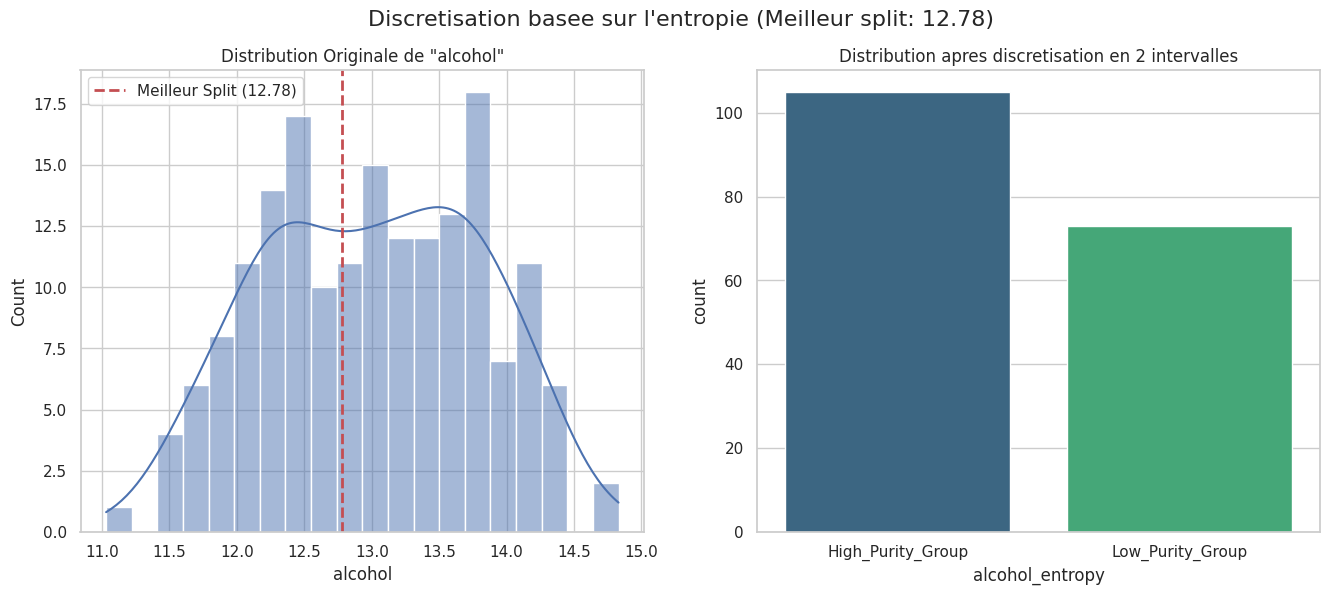

Distribution des classes dans chaque nouvel intervalle: 
target              0   1   2
alcohol_entropy              
High_Purity_Group  59   9  37
Low_Purity_Group    0  62  11


In [5]:
def calculate_entropy(target_counts):
    total=sum(target_counts)
    if total == 0:
        return 0
    entropy=0
    for count in target_counts:
        p = count /total
        if p>0:
            entropy -=p*np.log2(p)
    return entropy

def find_entropy(data, feature, target):
    best_split_point =None
    min_weighted_entropy = float('inf')

    unique_values =sorted(data[feature].unique())

    for i in range (len(unique_values) - 1):
        split_point=(unique_values[i]+ unique_values[i +1]) /2

        left_partition=data[data[feature] <= split_point]
        right_partition= data[data[feature] > split_point]

        entropy_left=calculate_entropy(left_partition[target].value_counts())
        entropy_right=calculate_entropy(right_partition[target].value_counts())

        n_total =len(data)
        weight_left = len(left_partition) / n_total
        weight_right = len(right_partition) /n_total

        weighted_entropy = (weight_left * entropy_left) + (weight_right * entropy_right)

        if weighted_entropy < min_weighted_entropy:
            min_weighted_entropy = weighted_entropy
            best_split_point= split_point
    return best_split_point

best_split= find_entropy(df_wine, feature, 'target')

df_wine['alcohol_entropy']= np.where(df_wine[feature] <= best_split, 'Low_Purity_Group', 'High_Purity_Group')

fig, axes=plt.subplots(1, 2, figsize=(16,6))
fig.suptitle(f'Discretisation basee sur l\'entropie (Meilleur split: {best_split:.2f})', fontsize=16)

sns.histplot(df_wine[feature], kde=True, ax=axes[0], bins=20)
axes[0].axvline(best_split, color='r', linestyle='--', linewidth=2, label=f'Meilleur Split ({best_split:.2f})')
axes[0].set_title(f'Distribution Originale de "{feature}"')
axes[0].legend()

sns.countplot(x=df_wine['alcohol_entropy'], ax=axes[1], palette='viridis')
axes[1].set_title(f'Distribution apres discretisation en 2 intervalles')
plt.show()

print("Distribution des classes dans chaque nouvel intervalle: ")
print(pd.crosstab(df_wine['alcohol_entropy'], df_wine['target']))